# Overview

This project originated in the CuraTime Hackathon 2025 in Mainz. The task builds up on the publication "AcrNET: predicting anti-CRISPR with deep learning" by Li et al. (https://doi.org/10.1093/bioinformatics/btad259). Here,
the authors designed a deep neural network to classify wether proteins are anti-CRISPR proteins and if so of which type.

The challenge was create a Machine learning pipelane capable of competing with the original design in the Paper. The code presented here builts up on the results achieved during the hackathon.


# Preparations

## Import Packages 

In [1]:
import numpy as np
import pandas as pd
import pickle
from tqdm import tqdm
import torch
import matplotlib.pyplot as plt
import seaborn as sbn
from time import time

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import ( train_test_split,
    cross_val_score,
    cross_val_predict,
    RandomizedSearchCV,
    StratifiedKFold
)
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    matthews_corrcoef
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from scipy.stats import randint, uniform
from transformers import AutoTokenizer, AutoModel

import protFeat
from protFeat.feature_extracter import extract_protein_feature, usage


## loading and Display the Data 

In [2]:
path_to_pkl = "data-and-performance/full binary dataset-5-fold-cross-valisation/"
with open(path_to_pkl + "full_dataset.pkl", "rb") as file:
    data = pickle.load(file)  

df = pd.read_pickle(path_to_pkl + "full_dataset.pkl")
labels = df["label"].to_numpy()
df

,sequence,label
0,MKFIKYLSTAHLNYMNIAVYENGSKIKARVENVVNGKSVGARDFDS...,1
1,MMTISKTDIDCYLQTYVVIDPVSNGWQWGIDENGVGGALHHGRVEM...,1
2,MSSTISDRIISRSVIEAARFIQSWEDADPDNLTESQVLAASSFAAR...,1
3,MSRPTVVTVTETPRNPGSYEVNVERDGKMVVGRARAGSDPGAAAAK...,1
4,MTIYLSNAIENATSIEQVVELINEGTCEGMEGIEFTADILAGQYAW...,1
...,...,...
2341,MQQTFNADMNISNLHQNVDPSTTLPVICGVEITTDRAGRYNLNALH...,0
2342,MSKLVWLDAGHGGKDSGAAANGIKEKDIVLKIVKKVKSILTSRYEV...,0
2343,MGYYSVGIPFLYFKIPFTNSIRLCILYSLIGRTSPIIERKQEKLML...,0
2344,MLAKVTFLSCITMSDFTFSGYELACFVTHSGLSRSAGHILSQCANL...,0


# Pipeline
The first step contains the design  of a binary classifier that reads in an amino acid sequence of a proteins and determines if this sequence belongs to an Anti CRISPR Protein or not. Our first objective is to increase the qualitity of the input data by converting the sequences first into usefull embeddings. Here, multiple approaches were used.

## Create Embeddings using feature representation schemese based on iFeature

In the first approached we used the python package protFeat (https://github.com/gozsari/ProtFeat) to extract feature representations based on based on Protein descriptors. And are given in an overview in their github repo:

![Sample Image](protein_descriptor.png)

### Conversion into Fasta Files 

As our original Data was only present in pkl files we first needed to convert them into the fasta format required by the package.

In [3]:
with open("output.fasta", "w") as fasta_file:
    for idx, row in df.iterrows():
        fasta_file.write(f">{idx}\n{row['sequence']}\n")

### Creation of feature vectors using Protfeat

Now we can extract feature vectors generated using iFeature (Position-Specific Scoring matrix-based feature generator for machine learning) 

In [4]:
methods_iFeature = ["AAC", "PAAC", "APAAC", "DPC", "GAAC", "CKSAAP", "CKSAAGP", "GDPC", "Moran", "Geary",
          	        "NMBroto", "CTDC", "CTDD", "CTDT", "CTriad", "KSCTriad", "SOCNumber", "QSOrder"]

# ready representations are already in folder: "./feature_extraction_output"

#path_to_foalder =  "./"
#for method in methods_iFeature:
#    extract_protein_feature(method, 0, path_to_foalder, "output")


### Test every description individually
With the features extracted, this created our first set of embeddings. We checked their individuall quality concerning the binary classification task by using a simple random forest classifyer and stratified 5-fold cross-validation. The results are stored in a pandas dataframe 

In [5]:
def benchmark(model, X, y):
    """
    Evaluates a classification model using stratified 5-fold cross-validation.

    This function performs cross-validated predictions and computes key performance
    metrics, including accuracy, precision, recall, F1-score, and Matthews
    correlation coefficient (MCC). It also generates a confusion matrix.

    Args:
        model (sklearn.base.BaseEstimator): 
            A scikit-learn compatible classification model.
        X (array-like): 
            Feature matrix of shape (n_samples, n_features).
        y (array-like): 
            Target labels of shape (n_samples,).
    Returns:
        tuple:
            A tuple containing the following elements:
            - accuracy (float): Overall accuracy of the model.
            - precision (float): Precision score.
            - recall (float): Recall score.
            - f1 (float): F1 score.
            - mcc (float): Matthews correlation coefficient.
            - conf_matrix (ndarray): Confusion matrix of shape (n_classes, n_classes).
    """
    
    #create splits of dataset and perform crossvalidation 
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)    
    cv_predictions = cross_val_predict(model, X, y, cv=skf)

    # evaluate models performance
    # Compute confusion matrix
    conf_matrix = confusion_matrix(y, cv_predictions)

    # Compute performance metrics
    accuracy = accuracy_score(y, cv_predictions)
    precision = precision_score(y, cv_predictions)
    recall = recall_score(y, cv_predictions)
    f1 = f1_score(y, cv_predictions)
    mcc = matthews_corrcoef(y, cv_predictions)

    return accuracy, precision, recall, f1, mcc, conf_matrix


In [6]:
def generate_entry(method, accuracy, precision, recall, f1, mcc, conf_matrix):
    """
    Generates Pandas Dataframe Entry to create clean human readable output for comparing different 
    methods used to create the embeddings

    Args:
        method ("string"): 
            Protein Descripture
        accuracy (float): 
            Overall accuracy of the model.
        precision (float):
            Precision score.
        recall (float):
            Recall score.
        f1 (float):
            F1 score.
        mcc (float): 
            Matthews correlation coefficient.
        conf_matrix (ndarray):
            Confusion matrix of shape (n_classes, n_classes).
    Returns:
        pandas DataFrame of organized input
    """
    
    
    new_entry = {
        "method": method,
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "mcc": mcc,
        "conf_matrix": conf_matrix
    }
    return pd.DataFrame([new_entry])
    

In [7]:
# create Dataframe for later comparision of all methods
columns = ["method", "accuracy", "precision", "recall", "f1", "mcc", "conf_matrix"]
df_result_overview = pd.DataFrame(columns=columns)

In [8]:
# create dataframe to store performances of the individual feature represenation
columns = ["method", "accuracy", "precision", "recall", "f1", "mcc", "conf_matrix"]
df_single_methods = pd.DataFrame(columns=columns)

# for each feature represenation evaluate their performance using a Random Forest
for index,  method in tqdm(enumerate(methods_iFeature)):   
    X = np.loadtxt("feature_extraction_output/output_" + method + ".txt")[:,1:]
    rf_reg = RandomForestClassifier(n_estimators=100, random_state=100)
    accuracy, precision, recall, f1, mcc, conf_matrix = benchmark(rf_reg, X, labels)
    new_entry = generate_entry(method, accuracy, precision, recall, f1, mcc, conf_matrix)
    df_single_methods = pd.concat([new_entry, df_single_methods], ignore_index=True)

df_single_methods.sort_values(by =["accuracy"], ascending = False)

18it [01:02,  3.45s/it]


,method,accuracy,precision,recall,f1,mcc,conf_matrix
12,CKSAAP,0.893009,0.947267,0.834459,0.887292,0.791971,"[[1107, 55], [196, 988]]"
14,DPC,0.880648,0.930476,0.825169,0.874664,0.766539,"[[1089, 73], [207, 977]]"
0,QSOrder,0.871270,0.897297,0.841216,0.868352,0.744151,"[[1048, 114], [188, 996]]"
11,CKSAAGP,0.858056,0.881614,0.830236,0.855154,0.717485,"[[1030, 132], [201, 983]]"
16,PAAC,0.856351,0.870516,0.840372,0.855178,0.713207,"[[1014, 148], [189, 995]]"
17,AAC,0.851236,0.869796,0.829392,0.849114,0.703350,"[[1015, 147], [202, 982]]"
15,APAAC,0.850384,0.865031,0.833615,0.849032,0.701315,"[[1008, 154], [197, 987]]"
5,CTDD,0.837170,0.864545,0.803209,0.832750,0.676263,"[[1013, 149], [233, 951]]"
3,CTriad,0.835038,0.869323,0.792230,0.828988,0.673022,"[[1021, 141], [246, 938]]"
2,KSCTriad,0.835038,0.869323,0.792230,0.828988,0.673022,"[[1021, 141], [246, 938]]"


In [9]:
df_result_overview = pd.concat([df_result_overview, df_single_methods.loc[[12]]],axis = 0, ignore_index=True)
df_result_overview

,method,accuracy,precision,recall,f1,mcc,conf_matrix
0,CKSAAP,0.893009,0.947267,0.834459,0.887292,0.791971,"[[1107, 55], [196, 988]]"


### Combinations of Representations

As different representation methods encode different information. It is checked in the next step to which extend the combination of features results in better classification results

In [10]:
columns = ["method", "accuracy", "precision", "recall", "f1", "mcc", "conf_matrix"]
df_representation_combinations = pd.DataFrame(columns=columns)

# for each feature represenation evaluate their performance using a Random Forest
X_base = np.loadtxt("feature_extraction_output/output_CKSAAP.txt")[:,1:]
for index,  method in tqdm(enumerate(methods_iFeature)):   
    #concatenate feature representation
    X_add = np.loadtxt("feature_extraction_output/output_" + method + ".txt")[:,1:]
    X = np.concat([X_base, X_add], axis = 1)
    
    rf_reg = RandomForestClassifier(n_estimators=100, random_state=100)
    accuracy, precision, recall, f1, mcc, conf_matrix = benchmark(rf_reg, X, labels)
    new_entry = generate_entry("CKSAAP + " +  method , accuracy, precision, recall, f1, mcc, conf_matrix)
    df_representation_combinations = pd.concat([new_entry, df_representation_combinations], ignore_index=True)

df_representation_combinations.sort_values(by =["accuracy"], ascending = False)

18it [02:04,  6.92s/it]


,method,accuracy,precision,recall,f1,mcc,conf_matrix
10,CKSAAP + GDPC,0.900256,0.958494,0.838682,0.894595,0.807166,"[[1119, 43], [191, 993]]"
5,CKSAAP + CTDD,0.900256,0.954981,0.842061,0.894973,0.806470,"[[1115, 47], [187, 997]]"
7,CKSAAP + NMBroto,0.898977,0.956606,0.837838,0.893291,0.804502,"[[1117, 45], [192, 992]]"
0,CKSAAP + QSOrder,0.898977,0.952245,0.842061,0.893770,0.803646,"[[1112, 50], [187, 997]]"
15,CKSAAP + APAAC,0.898551,0.958333,0.835304,0.892599,0.804094,"[[1119, 43], [195, 989]]"
14,CKSAAP + DPC,0.896846,0.952015,0.837838,0.891285,0.799777,"[[1112, 50], [192, 992]]"
8,CKSAAP + Geary,0.894288,0.957926,0.826858,0.887579,0.796445,"[[1119, 43], [205, 979]]"
16,CKSAAP + PAAC,0.894288,0.948276,0.836149,0.888689,0.794461,"[[1108, 54], [194, 990]]"
9,CKSAAP + Moran,0.893009,0.948989,0.832770,0.887090,0.792311,"[[1109, 53], [198, 986]]"
11,CKSAAP + CKSAAGP,0.892583,0.933086,0.847973,0.888496,0.788678,"[[1090, 72], [180, 1004]]"


In [11]:
df_result_overview = pd.concat([df_result_overview, df_representation_combinations.loc[[10]]],axis = 0, ignore_index=True)
df_result_overview

,method,accuracy,precision,recall,f1,mcc,conf_matrix
0,CKSAAP,0.893009,0.947267,0.834459,0.887292,0.791971,"[[1107, 55], [196, 988]]"
1,CKSAAP + GDPC,0.900256,0.958494,0.838682,0.894595,0.807166,"[[1119, 43], [191, 993]]"


### Do PCA of Embeddings 

As the accuracy increased slidely, all representations were combined in the next step. However, due to limited computational power large embedings resulted in longer calculations. Therefore, we decided to perform a PCA first. We extracted the most informative components and used only those to systematically try different classifyiers later in our pipeline significantly reducing our computational costs.

In [12]:
def do_pca(X, n_components = 0.5):
    """
    Performs Principal Component Analysis (PCA) on a given dataset.
    The number of components can be  specified either as an integer
    (number of components) or a float (percentage of variance to retain).

    Args:
        X (array-like): 
            Feature matrix of shape (n_samples, n_features).
        n_components (int or float, optional): 
            Number of principal components to keep. If float (between 0 and 1), 
            selects the number of components to retain the specified variance.
            Defaults to 0.5.

    Returns:
        ndarray:
            The transformed data of shape (n_samples, n_components).
    """
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X_scaled)
    return X_pca

def plot_pca(X, ax, title = "", Y = "tab:blue"):
    """
    Plots the first two principal components of a PCA-transformed dataset.

    This function creates a scatter plot of the first two PCA components, 
    optionally coloring the points based on labels or classes.

    Args:
        X (ndarray): 
            PCA-transformed data of shape (n_samples, 2).
        ax (matplotlib.axes.Axes): 
            Matplotlib Axes object to draw the plot on.
        title (str, optional): 
            Title for the plot. Defaults to an empty string.
        Y (str or array-like, optional): 
            Color or class labels for the data points. Can be a single color string 
            (e.g., "tab:blue") or an array of values to map to a colormap. 
            Defaults to "tab:blue".

    Returns:
        matplotlib.collections.PathCollection:
            The scatter plot object for further customization if needed.
    """
    scatter = ax.scatter(X[:, 0], X[:, 1], c=Y, cmap='viridis', edgecolor='k', alpha=0.3)
    ax.set_title(title)
    ax.set_xlabel("Principal Component 1")
    ax.set_ylabel("Principal Component 2")
    ax.set_ylim(np.amin(np.concat([X[:, 0], X[:, 1]])), np.amax(np.concat([X[:, 0], X[:, 1]])))
    ax.set_xlim(np.amin(np.concat([X[:, 0], X[:, 1]])), np.amax(np.concat([X[:, 0], X[:, 1]])))



In [13]:
# concatenate all feature by reading them in sequentially
X_complete = np.loadtxt("feature_extraction_output/output_AAC.txt")[:,1:]#
for method in methods_iFeature:
    X_new = np.loadtxt("feature_extraction_output/output_" + method + ".txt")[:,1:]#
    X_complete = np.concatenate((X_complete, X_new), axis = 1)
X_complete.shape

(2346, 4989)

Interestingly, already some structure can be seen when visualising the first two PCA components. 

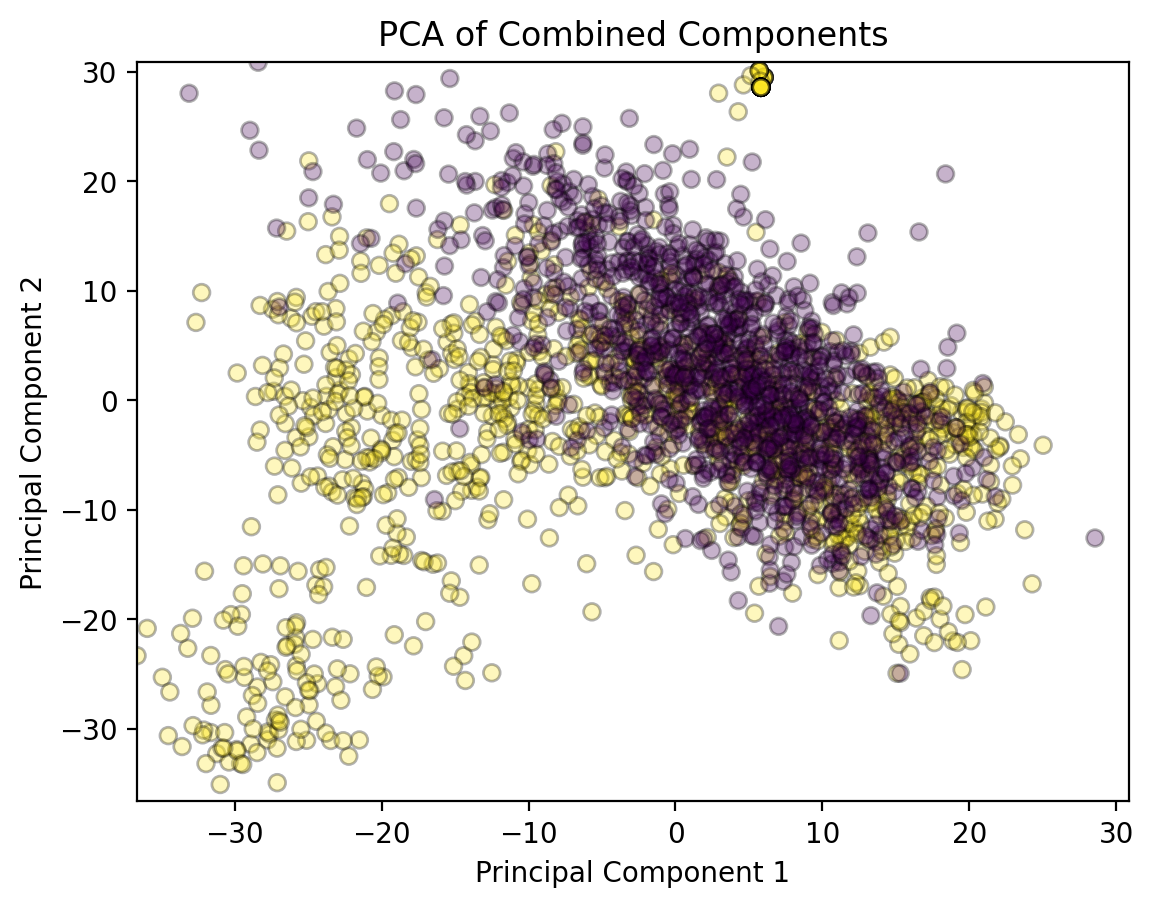

In [14]:
# calculate PCA of combined representation
X_pca = do_pca(X_complete, n_components = 0.999)
fig, ax  = plt.subplots(1,1, dpi = 200)
plot_pca(X_pca, ax,  title = "PCA of Combined Components", Y = labels)

But how many features are actually encoding information usefull for the task? We included different amounts of features ranging between 10 and 1000 into our analysis and checked their performance, again using a random forest classifyer.

In [15]:

columns = ["method", "accuracy", "precision", "recall", "f1", "mcc", "conf_matrix"]
df_pca = pd.DataFrame(columns=columns)

variances = np.logspace(0.3, 3, 20).astype(int)
for variance in tqdm(variances):
    rf_reg = RandomForestClassifier(n_estimators=100, random_state=100)
    accuracy, precision, recall, f1, mcc, conf_matrix = benchmark(rf_reg, X_pca[:,:variance], labels[:])
    new_entry = generate_entry( variance, accuracy, precision, recall, f1, mcc, conf_matrix)
    df_pca = pd.concat([new_entry, df_pca], ignore_index=True)

df_pca

100%|███████████████████████████████████████████████████████████████████████████████████| 20/20 [01:24<00:00,  4.22s/it]


,method,accuracy,precision,recall,f1,mcc,conf_matrix
0,1000,0.842711,0.917949,0.755912,0.829088,0.697037,"[[1082, 80], [289, 895]]"
1,720,0.864024,0.935549,0.784628,0.853468,0.738263,"[[1098, 64], [255, 929]]"
2,519,0.874254,0.934506,0.807432,0.866334,0.755947,"[[1095, 67], [228, 956]]"
3,374,0.884058,0.942718,0.820101,0.877145,0.775074,"[[1103, 59], [213, 971]]"
4,270,0.890878,0.933645,0.843750,0.886424,0.785649,"[[1091, 71], [185, 999]]"
5,194,0.898551,0.946226,0.847128,0.893939,0.801769,"[[1105, 57], [181, 1003]]"
6,140,0.887468,0.924354,0.846284,0.883598,0.777924,"[[1080, 82], [182, 1002]]"
7,101,0.896846,0.938547,0.851351,0.892826,0.797363,"[[1096, 66], [176, 1008]]"
8,72,0.898977,0.934803,0.859797,0.895733,0.800716,"[[1091, 71], [166, 1018]]"
9,52,0.900682,0.942326,0.855574,0.896857,0.804997,"[[1100, 62], [171, 1013]]"


In [16]:
df_result_overview = pd.concat([df_result_overview, df_pca.loc[[9]]],axis = 0, ignore_index=True)
df_result_overview

,method,accuracy,precision,recall,f1,mcc,conf_matrix
0,CKSAAP,0.893009,0.947267,0.834459,0.887292,0.791971,"[[1107, 55], [196, 988]]"
1,CKSAAP + GDPC,0.900256,0.958494,0.838682,0.894595,0.807166,"[[1119, 43], [191, 993]]"
2,52,0.900682,0.942326,0.855574,0.896857,0.804997,"[[1100, 62], [171, 1013]]"


The results show nicely that after only using around 10 components of the PCA a plateau in performance is reached in all quantities. The highest accuracy was obtained using 52 components. (Eventhough the results of other numbers of components seem to be well withing fluctuation ranges.)

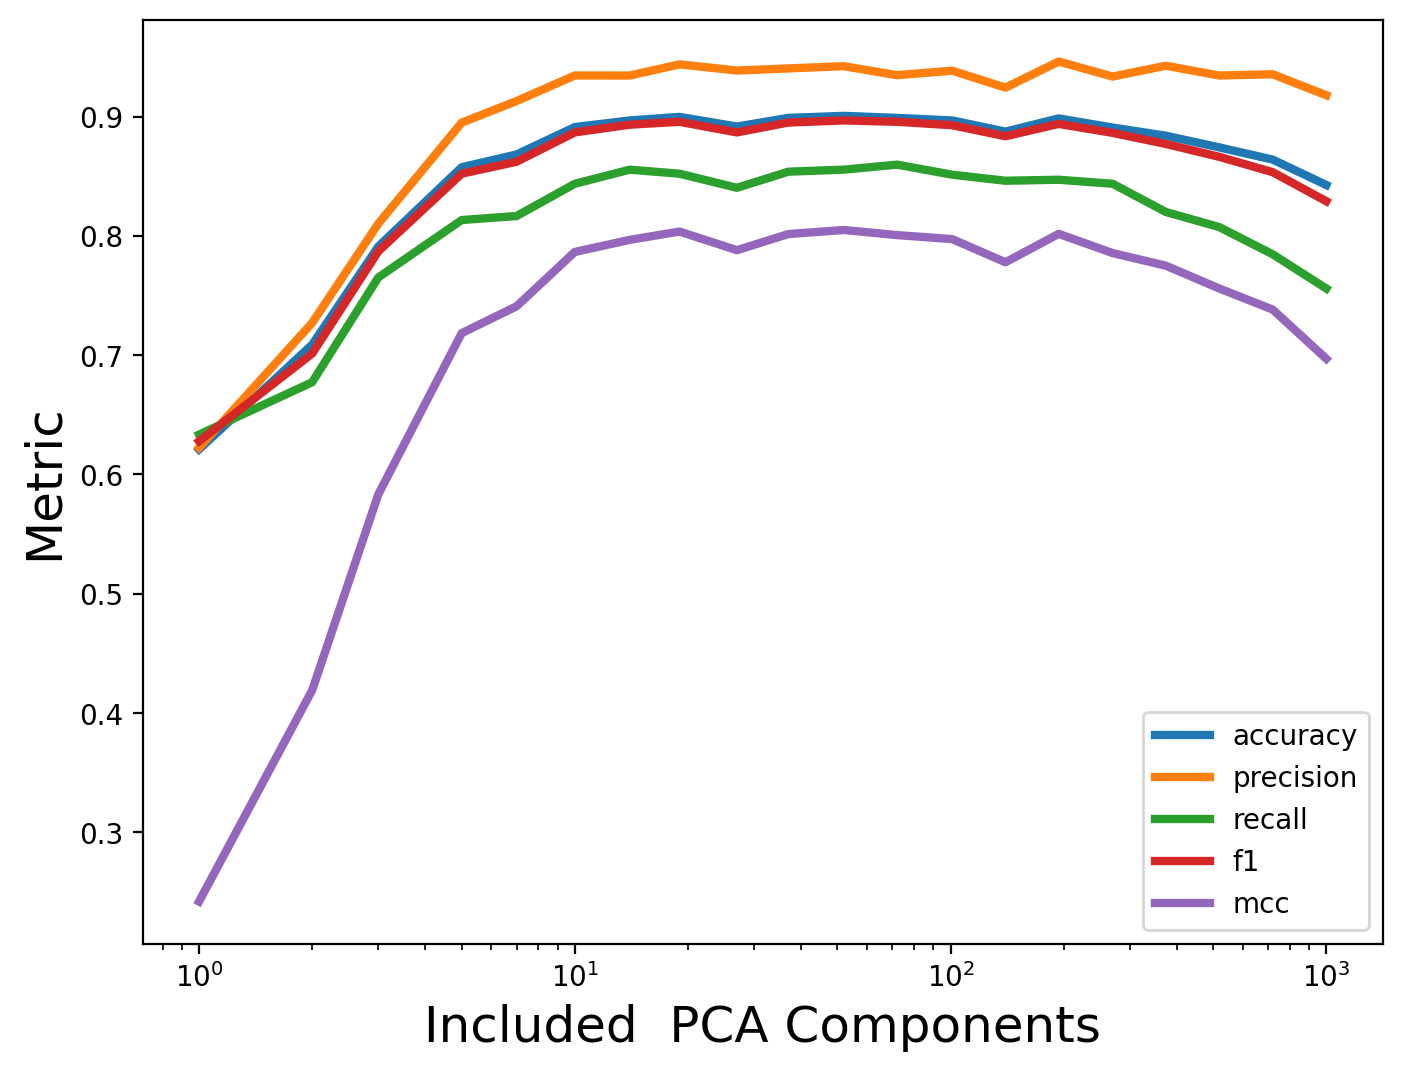

In [17]:
plt.figure(dpi = 200, figsize = (8,6))
plt.xlabel("Included  PCA Components", fontsize = 18)
plt.ylabel("Metric", fontsize = 18)
plt.plot(df_pca["method"].to_numpy(),df_pca["accuracy"].to_numpy(), label = "accuracy", linewidth = 3 )
plt.plot(df_pca["method"].to_numpy(),df_pca["precision"].to_numpy(), label = "precision", linewidth = 3 )
plt.plot(df_pca["method"].to_numpy(),df_pca["recall"].to_numpy() , label = "recall", linewidth = 3)
plt.plot(df_pca["method"].to_numpy(),df_pca["f1"].to_numpy() , label = "f1", linewidth = 3)
plt.plot(df_pca["method"].to_numpy(),df_pca["mcc"].to_numpy() , label = "mcc", linewidth = 3)
plt.xscale("log")
plt.legend()


Looking at the results of using (admittetly not an optimized) random forest tree for both embeddings. The complete and the PCA version. The PCA seems to outperform the complete embeddings and further does this around 4 times faster.

In [18]:
columns = ["method", "accuracy", "precision", "recall", "f1", "mcc", "conf_matrix", "time"]
df_comp = pd.DataFrame(columns=columns)

begin_pca = time()
rf_reg = RandomForestClassifier(n_estimators=100, random_state=100)
accuracy, precision, recall, f1, mcc, conf_matrix = benchmark(rf_reg, X_pca[:,:52], labels[:])
new_entry = generate_entry( "PCA", accuracy, precision, recall, f1, mcc, conf_matrix)
end_pca = time()
new_entry["time"] = end_pca - begin_pca
df_comp = pd.concat([new_entry, df_comp], ignore_index=True)

begin_complete = time()
rf_reg = RandomForestClassifier(n_estimators=100, random_state=100)
accuracy, precision, recall, f1, mcc, conf_matrix = benchmark(rf_reg, X_complete, labels[:])
end_complete = time()
new_entry = generate_entry( "Complete", accuracy, precision, recall, f1, mcc, conf_matrix)
new_entry["time"] = end_complete - begin_complete
df_comp = pd.concat([new_entry, df_comp], ignore_index=True)


df_comp

,method,accuracy,precision,recall,f1,mcc,conf_matrix,time
0,Complete,0.890878,0.933645,0.843750,0.886424,0.785649,"[[1091, 71], [185, 999]]",13.858497
1,PCA,0.900682,0.942326,0.855574,0.896857,0.804997,"[[1100, 62], [171, 1013]]",3.065104


### Classifyer optimization

We therefore proceeded by using the PCA representation of 52 components and did a systematic analysis of different standard classifyers. For this we tried support vector machines and random forests. In both cases we performed a random search and stored the best output parameters

In [19]:
# Define hyperparameter distribution
def perform_random_search(X, y, model, param_dist, n_iter = 50):
    """
    Performs randomized hyperparameter search with stratified 5-fold cross-validation.

    Args:
        X (array-like or pd.DataFrame): Feature matrix.
        y (array-like): Target vector.
        model (estimator): A scikit-learn compatible model (e.g., RandomForestClassifier).
        param_dist (dict): Dictionary of hyperparameters to sample from.
        n_iter (int, optional): Number of parameter settings to sample. Default is 50.

    Returns:
        RandomizedSearchCV: The fitted RandomizedSearchCV object containing the best estimator,
        best parameters, and cross-validation results.

    Prints:
        Best hyperparameter set found and corresponding cross-validated accuracy score.
    """
    
    strat_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    # Randomized Search
    random_search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_dist,
        n_iter=n_iter,
        cv=strat_kfold,  
        scoring='accuracy',
        verbose=0,
        random_state=42,
        n_jobs=-1
    )

    # Fit the search
    random_search.fit(X, y)
    
    # Output best results
    print("Best parameters found:", random_search.best_params_)
    print("Best cross-validated score:", random_search.best_score_)
    return random_search

In [20]:
# perform random search for hyperparameters using random forest
# only 5 iterations were used, as many increase the running time
rf = RandomForestClassifier(random_state=42)
param_dist = {
    'n_estimators': randint(10, 1000),
    'max_depth': randint(5, 50),
    'min_samples_split': randint(2, 11),
    'min_samples_leaf': randint(1, 11),
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False]
}

random_search_rf = perform_random_search(X_pca[:,:52], labels, rf, param_dist, n_iter = 5)

Best parameters found: {'bootstrap': False, 'max_depth': 48, 'max_features': 'log2', 'min_samples_leaf': 6, 'min_samples_split': 3, 'n_estimators': 201}
Best cross-validated score: 0.8968416277276233


In [21]:
# perform random search for hyperparameters using support vector machine
svc = SVC(probability=False)  
param_dist = {
    'C': uniform(0.1, 10),              
    'kernel': ['rbf', 'poly', 'sigmoid'] 
}

random_search_svc = perform_random_search(X_pca[:,:52], labels, svc, param_dist, n_iter = 50)


Best parameters found: {'C': np.float64(5.347564316322378), 'kernel': 'rbf'}
Best cross-validated score: 0.9300857415052397


In [22]:
C= random_search_svc.best_estimator_.get_params()["C"]
kernel= random_search_svc.best_estimator_.get_params()["kernel"]
svc = SVC(probability=False, C = C, kernel = kernel)  

accuracy, precision, recall, f1, mcc, conf_matrix = benchmark(svc, X_pca[:,:52], labels[:])
new_entry = generate_entry( "PCA + finetuning", accuracy, precision, recall, f1, mcc, conf_matrix)
df_result_overview = pd.concat([df_result_overview, new_entry],axis = 0, ignore_index=True)
df_result_overview



,method,accuracy,precision,recall,f1,mcc,conf_matrix
0,CKSAAP,0.893009,0.947267,0.834459,0.887292,0.791971,"[[1107, 55], [196, 988]]"
1,CKSAAP + GDPC,0.900256,0.958494,0.838682,0.894595,0.807166,"[[1119, 43], [191, 993]]"
2,52,0.900682,0.942326,0.855574,0.896857,0.804997,"[[1100, 62], [171, 1013]]"
3,PCA + finetuning,0.930094,0.949735,0.909628,0.929249,0.861013,"[[1105, 57], [107, 1077]]"


## ESM2 Embeddings

In a second step we wanted to compare how embeddings create by a Transformer based model compares to the protein descriptors from above. For that we used ESM2 (https://github.com/facebookresearch/esm). We used its pretrained weights to generate embeddings for our protein sequences. We tried different models which differed by the amount of parameters that they contain. Due to hard ware constraints, we were not able to use the model with 15 billion parameters as the RAM of the used GPU was not sufficient.

In [23]:
def load_esm_Model(path):
    """
    Loads a pretrained ESM model and tokenizer from the specified path and moves the model to the appropriate device.

    Args:
        path (str): Path to the pretrained ESM model and tokenizer.

    Returns:
        tuple: A tuple containing:
            - tokenizer (AutoTokenizer): The loaded tokenizer.
            - model (AutoModel): The loaded ESM model.
            - device (torch.device): The device the model is loaded onto (CPU or CUDA).
    """
    tokenizer = AutoTokenizer.from_pretrained(path)
    model = AutoModel.from_pretrained(path)
    
    # Move model to GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    model.eval()
    return tokenizer, model, device

def ems_embeddings(model, tokenizer, device):
    """
    Generates ESM embeddings for protein sequences using the given model and tokenizer.

    Args:
        model (AutoModel): Pretrained ESM model.
        tokenizer (AutoTokenizer): Corresponding tokenizer for the ESM model.
        device (torch.device): Device to run the model on (CPU or CUDA).

    Returns:
        np.ndarray: Array of embeddings where each row corresponds to a sequence's embedding.
    """
    
    path_to_pkl = "data-and-performance/full binary dataset-5-fold-cross-valisation/"
    df = pd.read_pickle(path_to_pkl + "full_dataset.pkl")
    sequences = df["sequence"].to_numpy()
    
    emb = []
    for sequence in tqdm(sequences):
        inputs = tokenizer(sequence, return_tensors="pt", truncation=True)
        # Move inputs to the same device as the model
        inputs = {k: v.to(device) for k, v in inputs.items()}
        
        with torch.no_grad():
            outputs = model(**inputs)
        
        embeddings = outputs.last_hidden_state  # (1, seq_len, hidden_size)
        emb.append(embeddings[0, 0].cpu().numpy())  # Move to CPU before converting to numpy
        
         # Free memory -> important for larger embeddings
        del inputs, outputs, embeddings
        torch.cuda.empty_cache()
    embeddings = np.array(emb)
    return embeddings

def extract_embeddings_from_esm2(path):
    """
    Loads an ESM model from the given path and extracts embeddings for a predefined dataset.

    Args:
        path (str): Path to the pretrained ESM model and tokenizer.

    Returns:
        np.ndarray: Array of protein sequence embeddings generated using the ESM model.
    """
    tokenizer, model, device = load_esm_Model(path)
    embeddings = ems_embeddings(model, tokenizer, device)
    del model, tokenizer
    torch.cuda.empty_cache()
    return embeddings

In [24]:
# Load tokenizer and model
path = "facebook/esm2_t6_8M_UR50D"
embeddings_8M = extract_embeddings_from_esm2(path)

path = "facebook/esm2_t30_150M_UR50D"
embeddings_150M = extract_embeddings_from_esm2(path)

path = "facebook/esm2_t33_650M_UR50D"
embeddings_650M = extract_embeddings_from_esm2(path)

path = "facebook/esm2_t36_3B_UR50D"
embeddings_3B = extract_embeddings_from_esm2(path)

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
100%|██████████████████████████████████████████████████████████████████████████████| 2346/2346 [00:10<00:00, 219.75it/s]
Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t30_150M_UR50D and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
100%|█████████████████████

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t36_3B_UR50D and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
100%|███████████████████████████████████████████████████████████████████████████████| 2346/2346 [02:18<00:00, 16.96it/s]


Visualisation of the latent space of the embeddings showed that with increasing amounts of parameters the non-anti-CRISPR proteins and anti-CRISPRproteins seemed to separate more.

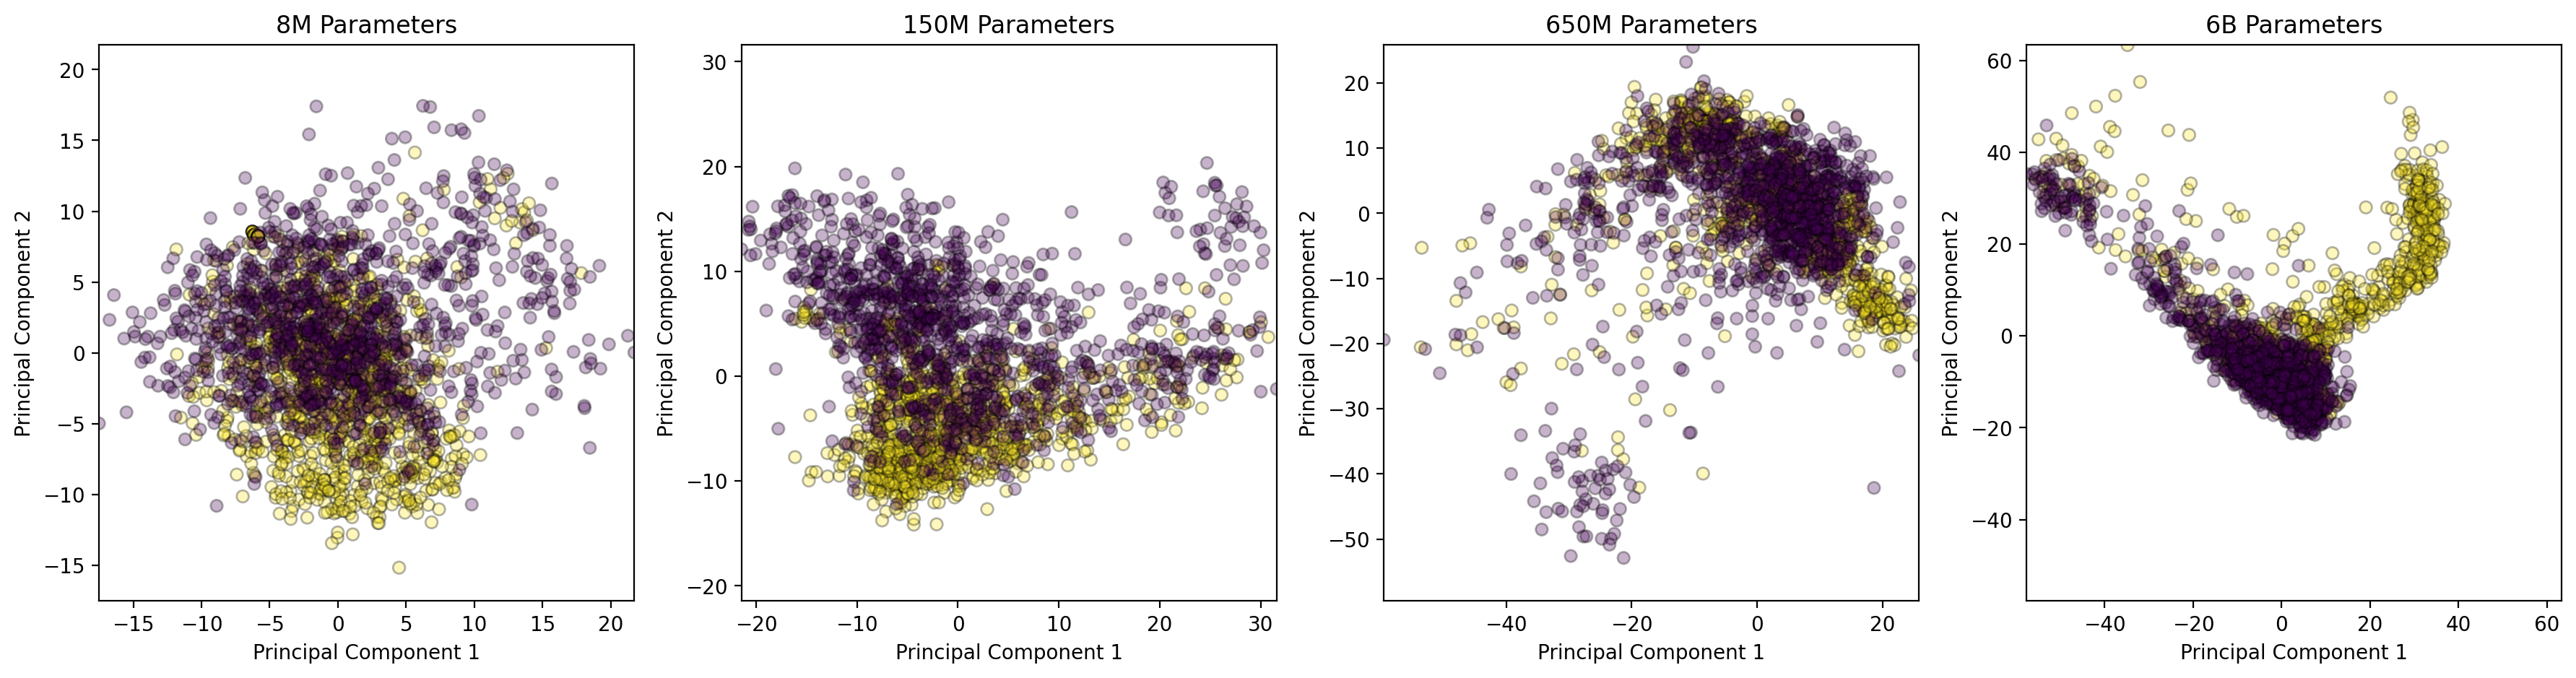

In [25]:
X_pca = do_pca(embeddings_8M)
fig, ax  = plt.subplots(1,4, dpi = 200, figsize = (22,5))
plot_pca(X_pca, ax[0],  title = "8M Parameters", Y = labels)

X_pca = do_pca(embeddings_150M)
plot_pca(X_pca, ax[1],  title = "150M Parameters", Y = labels)

X_pca = do_pca(embeddings_650M)
plot_pca(X_pca, ax[2],  title = "650M Parameters", Y = labels)

X_pca = do_pca(embeddings_3B)
plot_pca(X_pca, ax[3],  title = "6B Parameters", Y = labels)

From this intuition, we proceeded by quantifying the quality of the embeddings using SVCs and RFs to evaluate their performance.

the Randomforest fits were omitted as their running time became to large.

In [26]:
param_dist_RF = {
    'n_estimators': randint(10, 1000),
    'max_depth': randint(5, 50),
    'min_samples_split': randint(2, 11),
    'min_samples_leaf': randint(1, 11),
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False]
}

param_dist_SVC = {
    'C': uniform(0.1, 1000),              
    'kernel': ['rbf', 'poly', 'sigmoid'] 
}

# SVM model
svc_8 = SVC(probability=False)  
#rf_8 = RandomForestClassifier(random_state=42)
ramdon_fit_esm_8_SVC = perform_random_search(embeddings_8M, labels, svc_8, param_dist_SVC, n_iter = 250)
#ramdon_fit_esm_8_RF = perform_random_search(embeddings_8M, labels, rf_8, param_dist_RF, n_iter = 50)


svc_150 = SVC(probability=False)  
#rf_150 = RandomForestClassifier(random_state=42)
ramdon_fit_esm_150_SVC = perform_random_search(embeddings_150M, labels, svc_150, param_dist_SVC, n_iter = 250)
#ramdon_fit_esm_150_RF = perform_random_search(embeddings_150M, labels, rf_150, param_dist_RF, n_iter = 50)


svc_650 = SVC(probability=False)  
#rf_650 = RandomForestClassifier(random_state=42)
ramdon_fit_esm_650_SVC = perform_random_search(embeddings_650M, labels, svc_650, param_dist_SVC, n_iter = 250)
#ramdon_fit_esm_650_RF = perform_random_search(embeddings_650M, labels, rf_650, param_dist_RF, n_iter = 50)

svc_3B = SVC(probability=False)  
#rf_3B = RandomForestClassifier(random_state=42)
ramdon_fit_esm_3B_SVC = perform_random_search(embeddings_3B, labels, svc_3B, param_dist_SVC, n_iter = 250)
#ramdon_fit_esm_650_RF = perform_random_search(embeddings_3B, labels, rf_3B, param_dist_RF, n_iter = 50)

Best parameters found: {'C': np.float64(524.8564316322379), 'kernel': 'rbf'}
Best cross-validated score: 0.8780828380891894
Best parameters found: {'C': np.float64(300.9783098167697), 'kernel': 'rbf'}
Best cross-validated score: 0.9155931588259311
Best parameters found: {'C': np.float64(183.53478986616378), 'kernel': 'rbf'}
Best cross-validated score: 0.932224288889897
Best parameters found: {'C': np.float64(572.1041992091831), 'kernel': 'rbf'}
Best cross-validated score: 0.9377661842761874


In [27]:
C= ramdon_fit_esm_3B_SVC.best_estimator_.get_params()["C"]
kernel= ramdon_fit_esm_3B_SVC.best_estimator_.get_params()["kernel"]
svc = SVC(probability=False, C = C, kernel = kernel)   

accuracy, precision, recall, f1, mcc, conf_matrix = benchmark(svc, embeddings_3B, labels[:])
new_entry = generate_entry( "Embeddings 3B", accuracy, precision, recall, f1, mcc, conf_matrix)

df_result_overview = pd.concat([df_result_overview, new_entry],axis = 0, ignore_index=True)
df_result_overview


,method,accuracy,precision,recall,f1,mcc,conf_matrix
0,CKSAAP,0.893009,0.947267,0.834459,0.887292,0.791971,"[[1107, 55], [196, 988]]"
1,CKSAAP + GDPC,0.900256,0.958494,0.838682,0.894595,0.807166,"[[1119, 43], [191, 993]]"
2,52,0.900682,0.942326,0.855574,0.896857,0.804997,"[[1100, 62], [171, 1013]]"
3,PCA + finetuning,0.930094,0.949735,0.909628,0.929249,0.861013,"[[1105, 57], [107, 1077]]"
4,Embeddings 3B,0.937766,0.925410,0.953547,0.939268,0.875899,"[[1071, 91], [55, 1129]]"


## Combination of both Embeddings
In a last step we combined both approaches by concatenating the features and applying a PCA on them.

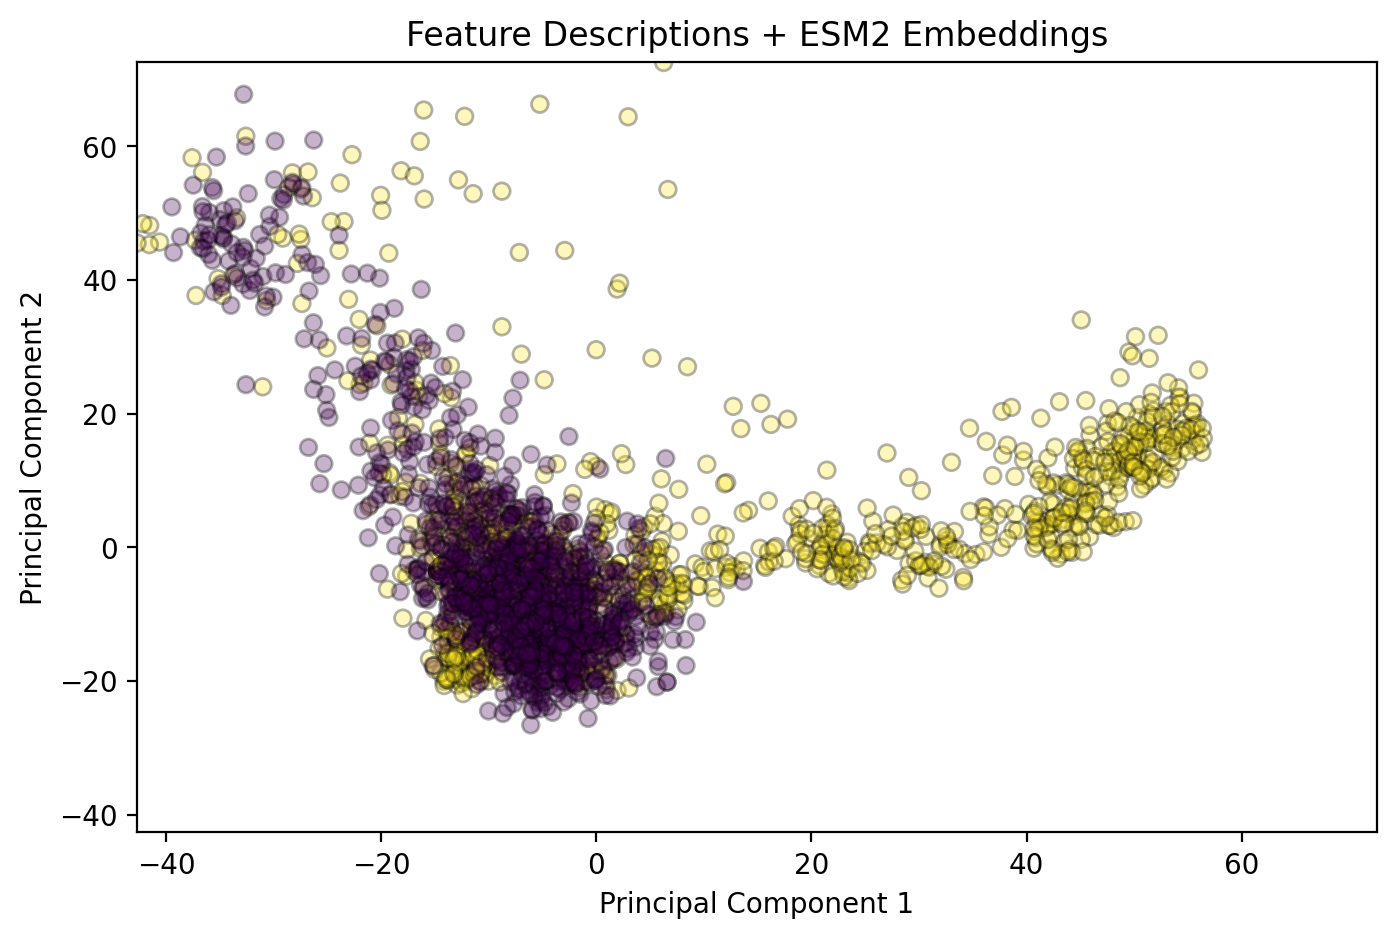

In [28]:
X_combined = np.concatenate([X_complete, embeddings_3B], axis = 1)
X_pca_feature_extraction = do_pca(X_combined)

fig, ax  = plt.subplots(1,1, dpi = 200, figsize = (8,5))
plot_pca(X_pca_feature_extraction, ax,  title = "Feature Descriptions + ESM2 Embeddings", Y = labels)



The best results are obtained by the combination of the PCA of the two embeddings.

In [29]:
param_dist_SVC = {
    'C': uniform(0.1, 1000),              
    'kernel': ['rbf', 'poly', 'sigmoid'] 
}


svc_combined = SVC(probability=False)  
ramdon_fit_esm_combined = perform_random_search(X_pca_feature_extraction[:, :1000], labels, svc_combined, param_dist_SVC, n_iter = 250)


Best parameters found: {'C': np.float64(43.70377175443375), 'kernel': 'poly'}
Best cross-validated score: 0.9479889307263077


In [30]:
C= ramdon_fit_esm_combined.best_estimator_.get_params()["C"]
kernel= ramdon_fit_esm_combined.best_estimator_.get_params()["kernel"]

In [31]:
svc_combined = SVC(probability=False, C =C, kernel =kernel )  
accuracy, precision, recall, f1, mcc, conf_matrix = benchmark(svc_combined, X_pca_feature_extraction[:,:1000], labels[:])
new_entry = generate_entry( "PCA + Embedding", accuracy, precision, recall, f1, mcc, conf_matrix)
df_result_overview  = pd.concat([new_entry, df_result_overview ])

## Embedding results overview

In [32]:
df_result_overview 

,method,accuracy,precision,recall,f1,mcc,conf_matrix
0,PCA + Embedding,0.947997,0.962544,0.933277,0.947684,0.896436,"[[1119, 43], [79, 1105]]"
0,CKSAAP,0.893009,0.947267,0.834459,0.887292,0.791971,"[[1107, 55], [196, 988]]"
1,CKSAAP + GDPC,0.900256,0.958494,0.838682,0.894595,0.807166,"[[1119, 43], [191, 993]]"
2,52,0.900682,0.942326,0.855574,0.896857,0.804997,"[[1100, 62], [171, 1013]]"
3,PCA + finetuning,0.930094,0.949735,0.909628,0.929249,0.861013,"[[1105, 57], [107, 1077]]"
4,Embeddings 3B,0.937766,0.925410,0.953547,0.939268,0.875899,"[[1071, 91], [55, 1129]]"


# Outlook (17.04.2025)

1) In the original paper the model architecture was tested on 3 different splits of the dataset in which only certain types of the anti-CRISPR proteins were part of the test sets while others were only part of the training set, creating non matching training and test distributions. The combination of the two embeddings found above will be tested on these scenarios as well and eventually refined.

2) The resulting embeddings will be used as input for a multiclassification of the anti-CRISPR proteins
